# Mafia — Per-Game Outcome Modeling (Pre-Game Only)

Goal: predict the **winning side** (mafia vs citizens) from the lineup and past form.
- Label per team row: `team_win_team` (1/0)
- Validation: GroupKFold by `game_id` + chronological holdout by `game_max_id`
- Metrics: LogLoss (primary), ROC-AUC, Brier, per-game accuracy
- Features: per-player Elo & rolling stats → aggregated to team → deltas (mafia - citizens)


In [1]:
# pip install pandas numpy lightgbm scikit-learn pyarrow fastparquet
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

DATA_PLAYERS = Path("cleaned/mafia_clean.csv")  # cleaned player-level dataset
OUT_DIR = Path("./team_data"); OUT_DIR.mkdir(exist_ok=True, parents=True)
ARTS = Path("./artifacts_game"); ARTS.mkdir(exist_ok=True, parents=True)
SEED = 42
np.random.seed(SEED)

## 1) Load cleaned player-level data
We expect: 10 rows per game, 3 mafia / 7 citizens, winners per game ∈ {3,7}, no duplicates.

In [2]:
df = pd.read_csv(DATA_PLAYERS)
df.shape, df.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_27188\3333621096.py:1: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PLAYERS)


((802820, 21),
         id  game_id  place  player_id original_nickname   role  killed_first  \
 0  1000001   100001     10          2             Teddy    red             0   
 1  1000002   100001      7         26          Искатель    red             0   
 2  1000003   100001      9         50             Лоску  black             0   
 
    best_move  game_points  game_autobonus  ...  best_move_bonus  penalty  \
 0          0          0.0             0.0  ...              0.0      0.0   
 1          0          0.0             0.0  ...              0.0      0.0   
 2          0          2.0             0.0  ...              0.0      0.0   
 
    fouls  penalty_disciplinary   Ci  created_at updated_at      team team_win  \
 0    0.0                   0.0  0.0         NaN        NaN  citizens        0   
 1    0.0                   0.0  0.0         NaN        NaN  citizens        0   
 2    0.0                   0.0  0.0         NaN        NaN     mafia        1   
 
    total_points  


## 2) Pre-game player features: Elo + rolling stats (leakage-safe)
- Sort by `id` (time proxy).
- Elo updates only from past results.
- Rolling win rate (5, 20), career win rate, games played.

In [3]:
# Inspect distribution of per-player id gaps
tmp = (df.sort_values(['player_id','id'])
         .groupby('player_id')['id']
         .diff()
         .dropna())
print(tmp.describe(percentiles=[.5,.8,.9,.95,.99]))

# Choose a threshold (start with the 95th percentile as a proxy)
GAP_THRESH = tmp.quantile(0.95)
print("Chosen GAP_THRESH (id units):", GAP_THRESH)

count    732003.000000
mean        135.976756
std        1368.720034
min           1.000000
50%          42.000000
80%         127.000000
90%         228.000000
95%         381.000000
99%        1174.000000
max      245724.000000
Name: id, dtype: float64
Chosen GAP_THRESH (id units): 381.0


## Temporal ELO decay
Scale each ELO update by exp(-gap/τ) where gap is the player's id-gap since last game.
- τ controls how fast old games “fade” (τ=400).
- Uses per-player gap computed on the fly; still pre-game safe (we take `pre_elo*` before updating).


In [ ]:
def compute_elos(df, init=1500, k=24, tau=400.0):
    """
    Pre-game ELO features with **temporal decay** on updates.
    - pre_elo:       global player skill
    - pre_elo_side:  skill by side ('mafia'/'citizens')
    - pre_elo_role:  skill by role ('don'/'black'/'sheriff'/'red')
    decay factor per player update: exp( - gap_id_player / tau )
    """
    d = df.sort_values('id').copy()

    elo_global = {}
    elo_side   = {}  # (player_id, side)
    elo_role   = {}  # (player_id, role)
    last_seen  = {}  # player_id -> last id seen

    outs = []

    for gid, g in d.groupby('game_id', sort=False):
        cur = g.copy()
        cur['pre_elo']       = [elo_global.get(pid, init) for pid in cur['player_id']]
        cur['pre_elo_side']  = [elo_side.get((pid, team), init) for pid, team in zip(cur['player_id'], cur['team'])]
        cur['pre_elo_role']  = [elo_role.get((pid, role), init) for pid, role in zip(cur['player_id'], cur['role'])]

        maf_mask = cur['team'].eq('mafia')
        mafia_mean = cur.loc[maf_mask, 'pre_elo'].mean()
        cit_mean   = cur.loc[~maf_mask, 'pre_elo'].mean()
        exp_mafia  = 1.0 / (1.0 + 10 ** ((cit_mean - mafia_mean)/400))

        mafia_res = int(cur.loc[maf_mask, 'team_win'].iloc[0])

        # update AFTER the game with **decay**
        for _, r in cur.iterrows():
            pid, side, role, rid = int(r['player_id']), r['team'], r['role'], int(r['id'])
            gap = rid - last_seen.get(pid, rid)  # 0 for first appearance
            decay = float(np.exp(-max(gap, 0) / float(tau)))

            exp = exp_mafia if side == 'mafia' else (1 - exp_mafia)
            act = mafia_res   if side == 'mafia' else (1 - mafia_res)
            delta = k * decay * (act - exp)

            elo_global[pid] = elo_global.get(pid, init) + delta
            elo_side[(pid, side)] = elo_side.get((pid, side), init) + delta
            elo_role[(pid, role)] = elo_role.get((pid, role), init) + delta
            last_seen[pid] = rid

        outs.append(cur[['game_id','player_id','pre_elo','pre_elo_side','pre_elo_role']])

    elo_df = pd.concat(outs, ignore_index=True)
    return d.merge(elo_df, on=['game_id','player_id'], how='left')

def add_rolling_stats_side(df, windows=(5, 20)):
    """
    Adds BOTH:
    - Generic per-player rolling: roll{w}_win_rate, games_played, career_win_rate
    - Side-specific rolling:      roll{w}_win_rate_mafia, roll{w}_win_rate_citizens
    All computed leakage-safe (uses shift(1)).
    """
    df = df.sort_values(['player_id','id']).copy()
    out = []
    for pid, g in df.groupby('player_id', sort=False):
        g = g.copy()
        g['win_shift'] = g['team_win'].shift(1)

        # Generic rolling win-rates (all games for this player)
        for w in windows:
            g[f'roll{w}_win_rate'] = g['win_shift'].rolling(w, min_periods=1).mean()

        # Side-specific rolling win-rates
        for side in ['mafia','citizens']:
            mask = g['team'].eq(side)
            for w in windows:
                g.loc[mask, f'roll{w}_win_rate_{side}'] = g.loc[mask, 'win_shift'].rolling(w, min_periods=1).mean()

        # Career stats (overall)
        g['games_played']   = np.arange(len(g))               # 0,1,2,... (pre-game count for current row)
        g['career_win_rate'] = g['win_shift'].expanding().mean()

        g.drop(columns=['win_shift'], inplace=True)
        out.append(g)
    return pd.concat(out, ignore_index=True)

def add_break_features(df, gap_thresh):
    """
    Adds:
    - gap_id: id difference since last game for this player (NaN for first game)
    - long_break_flag: 1 if gap_id >= gap_thresh else 0
    - gap_id_clipped: replace NaN with 0, clip huge tails for stability
    """
    d = df.sort_values(['player_id','id']).copy()
    d['gap_id'] = d.groupby('player_id')['id'].diff()
    d['gap_id_clipped'] = d['gap_id'].fillna(0).clip(lower=0)
    d['long_break_flag'] = (d['gap_id_clipped'] >= gap_thresh).astype('int8')
    return d.sort_values('id').reset_index(drop=True)

bins  = [0, 200_000, 400_000, 600_000, 800_000, 1_000_000_000]
labels= [1, 2, 3, 4, 5]
df = df.copy()
df['meta_period'] = pd.cut(df['id'], bins=bins, labels=labels, include_lowest=True).astype('int8')

work_players = compute_elos(df, init=1500, k=24, tau=400.0)
work_players = work_players.merge(df[['id','meta_period']], on='id', how='left')
work_players = add_rolling_stats_side(work_players)
work_players = add_break_features(work_players, GAP_THRESH)

## Role-specific history (player-level)
We add pre-game features that track a player's performance **on the exact role**:
- `win_rate_role_<role>_lastW` for W in {5, 20, 50}
- `games_in_role`: count of prior games on this role
All computed with chronological order by `id` and `.shift(1)` to avoid leakage.


In [5]:
def add_role_history_stats(df, windows=(5, 20, 50)):
    """
    For each (player_id, role), compute:
      - games_in_role: prior count before current game
      - rolling win rates on this role using only past outcomes
        => win_rate_role_<role>_last{W}
    """
    df = df.sort_values(['player_id', 'role', 'id']).copy()
    out = []

    for (pid, role), g in df.groupby(['player_id', 'role'], sort=False):
        g = g.copy()
        # Prior outcomes only
        past = g['team_win'].shift(1)

        # Experience in this role
        g['games_in_role'] = np.arange(len(g))  # 0,1,2... before current

        # Rolling, role-specific winrates
        for w in windows:
            g[f'win_rate_role_{role}_last{w}'] = past.rolling(w, min_periods=1).mean()

        out.append(g)

    return pd.concat(out, ignore_index=True).sort_values('id').reset_index(drop=True)

work_players = add_role_history_stats(work_players, windows=(5,20,50))

# Quick peek
cols_preview = ['game_id','team','player_id','role','games_in_role',
                'win_rate_role_don_last20','win_rate_role_black_last20',
                'win_rate_role_sheriff_last20','win_rate_role_red_last20']
existing = [c for c in cols_preview if c in work_players.columns]
work_players[existing].head()


,game_id,team,player_id,role,games_in_role,win_rate_role_don_last20,win_rate_role_black_last20,win_rate_role_sheriff_last20,win_rate_role_red_last20
0,100001,citizens,2,red,0,NaN,NaN,NaN,NaN
1,100001,citizens,26,red,0,NaN,NaN,NaN,NaN
2,100001,mafia,50,black,0,NaN,NaN,NaN,NaN
3,100001,mafia,74,black,0,NaN,NaN,NaN,NaN
4,100001,citizens,98,red,0,NaN,NaN,NaN,NaN


In [6]:
# This preview now works again:
work_players[['game_id','team','player_id',
              'pre_elo',
              'roll5_win_rate','roll20_win_rate','career_win_rate','games_played']].head()

,game_id,team,player_id,pre_elo,roll5_win_rate,roll20_win_rate,career_win_rate,games_played
0,100001,citizens,2,1500.0,NaN,NaN,NaN,0
1,100001,citizens,26,1500.0,NaN,NaN,NaN,0
2,100001,mafia,50,1500.0,NaN,NaN,NaN,0
3,100001,mafia,74,1500.0,NaN,NaN,NaN,0
4,100001,citizens,98,1500.0,NaN,NaN,NaN,0


### Synergy features (co-play history)
For each game and team, compute how many times each pair of teammates had previously played together on the **same side**. Aggregate within the team (mean, max). Uses chronological order by `id`, no leakage.


In [7]:
from itertools import combinations

def add_synergy_features(df):
    """
    For each game_id and team:
      - Compute prior same-team co-plays for all unordered pairs within that team (before this game).
      - Store team-level aggregates: synergy_mean_team, synergy_max_team.
    Implementation detail:
      - Iterate games in chronological order (by max id in the game).
      - Maintain a dictionary that counts how many times pair (a,b) have co-played on a given side.
    """
    df = df.copy()
    # game chronological order (by last id within game)
    game_order = (df.groupby('game_id')['id'].max()
                    .sort_values().index.tolist())

    # dict key: (min(pid), max(pid), team) -> count of prior co-plays on that team
    pair_counts = {}

    # output rows: (game_id, team, synergy_mean, synergy_max)
    out_rows = []

    for gid in game_order:
        g = df[df['game_id'] == gid]
        for team in ['mafia', 'citizens']:
            team_players = g.loc[g['team'] == team, 'player_id'].tolist()
            pair_vals = []
            for a, b in combinations(sorted(team_players), 2):
                key = (a, b, team)
                pair_vals.append(pair_counts.get(key, 0))

            if len(pair_vals) == 0:
                s_mean, s_max = 0.0, 0.0
            else:
                s_mean = float(np.mean(pair_vals))
                s_max  = float(np.max(pair_vals))

            out_rows.append((gid, team, s_mean, s_max))

        # AFTER recording features, update counts with this game
        for team in ['mafia', 'citizens']:
            team_players = g.loc[g['team'] == team, 'player_id'].tolist()
            for a, b in combinations(sorted(team_players), 2):
                key = (a, b, team)
                pair_counts[key] = pair_counts.get(key, 0) + 1

    team_synergy = pd.DataFrame(out_rows, columns=['game_id','team','synergy_mean_team','synergy_max_team'])
    # attach to every player-row (team-wise constant)
    return df.merge(team_synergy, on=['game_id','team'], how='left')

# AFTER: call it
work_players = add_synergy_features(work_players)
work_players[['game_id','team','synergy_mean_team','synergy_max_team']].head()


,game_id,team,synergy_mean_team,synergy_max_team
0,100001,citizens,0.0,0.0
1,100001,citizens,0.0,0.0
2,100001,mafia,0.0,0.0
3,100001,mafia,0.0,0.0
4,100001,citizens,0.0,0.0


### Streak features (momentum)
Compute per-player **pre-game** win_streak and loss_streak using only past results. Aggregate to team (mean, max).


In [8]:
def add_streak_features(df):
    """
    Adds per-player pre-game streaks:
      - win_streak: consecutive wins ending just before this game
      - loss_streak: consecutive losses ending just before this game
    """
    df = df.sort_values(['player_id','id']).copy()
    win_streaks = []
    loss_streaks = []

    for pid, g in df.groupby('player_id', sort=False):
        prev = g['team_win'].shift(1).values  # past outcomes only
        w_stk = np.zeros(len(g), dtype=np.int16)
        l_stk = np.zeros(len(g), dtype=np.int16)
        cur_w, cur_l = 0, 0
        for i, v in enumerate(prev):
            if np.isnan(v):
                cur_w, cur_l = 0, 0
            else:
                if v == 1:  # previous result was win
                    cur_w += 1
                    cur_l = 0
                else:       # previous result was loss
                    cur_l += 1
                    cur_w = 0
            w_stk[i] = cur_w
            l_stk[i] = cur_l
        win_streaks.append(pd.Series(w_stk, index=g.index))
        loss_streaks.append(pd.Series(l_stk, index=g.index))

    df['win_streak']  = pd.concat(win_streaks).sort_index()
    df['loss_streak'] = pd.concat(loss_streaks).sort_index()
    return df.sort_values('id').reset_index(drop=True)

# AFTER: call it
work_players = add_streak_features(work_players)
work_players[['game_id','player_id','win_streak','loss_streak']].head()


,game_id,player_id,win_streak,loss_streak
0,100001,2,0,0
1,100001,26,0,0
2,100001,50,0,0
3,100001,74,0,0
4,100001,98,0,0


### Games played to date (per player)
Cumulative count of past games per player (pre-game). Useful as a general “experience” signal.


In [ ]:
def add_games_played_feature(df):
    d = df.sort_values(['player_id','id']).copy()
    # number of *prior* appearances (shift to avoid leakage)
    d['games_played'] = d.groupby('player_id').cumcount().astype('int32')
    return d.sort_values('id').reset_index(drop=True)

work_players = add_games_played_feature(work_players)


## Enemy familiarity (cross-team co-history)
For each game_id: count how many times each player faced each opponent in previous games.
Aggregate to team-level (mean/max).


In [9]:
from itertools import product

def add_enemy_familiarity_features(df):
    """
    For each game:
      - For each player p in team A and q in team B, look up how many previous times p faced q on opposite teams.
      - Aggregate per team: enemy_fam_mean_team, enemy_fam_max_team.
    """
    d = df.sort_values('id').copy()
    game_order = (d.groupby('game_id')['id'].max().sort_values().index.tolist())

    faced_counts = {}  # key=(min(pid),max(pid)) -> count of prior *opposite-team* meetings
    out_rows = []

    for gid in game_order:
        g = d[d['game_id'] == gid]
        maf = g[g['team']=='mafia']['player_id'].dropna().astype(int).tolist()
        cit = g[g['team']=='citizens']['player_id'].dropna().astype(int).tolist()

        # current features (use counts BEFORE update)
        pairs_maf = [faced_counts.get(tuple(sorted([a,b])), 0) for a,b in product(maf, cit)]
        pairs_cit = [faced_counts.get(tuple(sorted([a,b])), 0) for a,b in product(cit, maf)]

        def stats(vals):
            return (float(np.mean(vals)) if vals else 0.0,
                    float(np.max(vals))  if vals else 0.0)

        maf_mean, maf_max = stats(pairs_maf)
        cit_mean, cit_max = stats(pairs_cit)

        out_rows.append((gid,'mafia',    maf_mean, maf_max))
        out_rows.append((gid,'citizens', cit_mean, cit_max))

        # AFTER computing features, update counts from this game
        for a,b in product(maf, cit):
            key = tuple(sorted([int(a),int(b)]))
            faced_counts[key] = faced_counts.get(key, 0) + 1

    fam = pd.DataFrame(out_rows, columns=['game_id','team','enemy_fam_mean_team','enemy_fam_max_team'])
    return d.merge(fam, on=['game_id','team'], how='left')

# === AFTER: call it in the pipeline BEFORE build_team_agg ===
work_players = add_enemy_familiarity_features(work_players)


### Sanity check

In [34]:
needed = ['pre_elo','pre_elo_side','pre_elo_role','gap_id_clipped','long_break_flag',
          'place','games_played','win_streak','loss_streak','synergy_mean_team',
          'synergy_max_team','enemy_fam_mean_team','enemy_fam_max_team',
          'roll5_win_rate_mafia','roll20_win_rate_mafia',
          'roll5_win_rate_citizens','roll20_win_rate_citizens','meta_period']
missing = [c for c in needed if c not in work_players.columns]
print("Missing columns:", missing)

Missing columns: ['win_streak', 'loss_streak']


## 3) Team aggregation with role history
Aggregate role-specific player history to team-level:
- Don & Sheriff: singletons (use their values)
- Black/Red: means across those players
Compute safe opponent-relative features:
- deltas (mafia - citizens)
- ratios ( (mafia + eps) / (citizens + eps) ), no labels included



In [32]:
def q25(x): return x.quantile(0.25)

def q75(x): return x.quantile(0.75)

def build_team_agg(work_players, add_ratios=True, ratio_eps=1e-3):
    agg_funcs = {}

    # helper to add aggregates only if the columns exist
    def add_agg(col, funcs):
        if col in work_players.columns:
            agg_funcs[col] = funcs

    # core blocks
    add_agg('pre_elo', ['mean','std','min','max', q25, q75])
    add_agg('pre_elo_side', ['mean'])
    add_agg('pre_elo_role', ['mean'])
    add_agg('gap_id_clipped', ['mean','max'])
    add_agg('long_break_flag', ['sum'])
    add_agg('place', ['mean','std','min','max'])
    add_agg('games_played', ['mean','std','min','max'])

    # optional blocks (only if present)
    add_agg('win_streak', ['mean','max'])
    add_agg('loss_streak', ['mean','max'])
    add_agg('synergy_mean_team', ['mean'])
    add_agg('synergy_max_team',  ['mean'])
    add_agg('enemy_fam_mean_team', ['mean'])
    add_agg('enemy_fam_max_team',  ['mean'])
    add_agg('roll5_win_rate_mafia',  ['mean'])
    add_agg('roll20_win_rate_mafia', ['mean'])
    add_agg('roll5_win_rate_citizens',  ['mean'])
    add_agg('roll20_win_rate_citizens', ['mean'])
    
    if 'meta_period' in work_players.columns:
        agg_funcs['meta_period'] = ['first']

    base = work_players.groupby(['game_id','team']).agg(agg_funcs)
    base.columns = ['_'.join([c for c in map(str, col) if c and c!='<function ' and c!='>'])
                    for col in base.columns]
    base = base.reset_index()

    # full (game_id,team) index to align role series
    full_idx = base.set_index(['game_id','team']).index

    def single_role_stat(role, value_col, out_name):
        s = (work_players[work_players['role'] == role]
             .groupby(['game_id','team'])[value_col].mean()).reindex(full_idx)
        s.name = out_name
        return s

    def mean_role_stat(role, value_col, out_name):
        s = (work_players[work_players['role'] == role]
             .groupby(['game_id','team'])[value_col].mean()).reindex(full_idx)
        s.name = out_name
        return s

    # Role-specific Elo & seats (as before)
    don_elo       = single_role_stat('don',     'pre_elo_role', 'don_pre_elo_role')
    sheriff_elo   = single_role_stat('sheriff', 'pre_elo_role', 'sheriff_pre_elo_role')
    don_place     = single_role_stat('don',     'place',        'don_place')
    sheriff_place = single_role_stat('sheriff', 'place',        'sheriff_place')
    black_elo_mean= mean_role_stat('black',     'pre_elo_role', 'black_mean_pre_elo_role')
    red_elo_mean  = mean_role_stat('red',       'pre_elo_role', 'red_mean_pre_elo_role')

    # NEW — role history: games_in_role
    don_games   = single_role_stat('don',     'games_in_role', 'don_games_in_role')
    sheriff_games  = single_role_stat('sheriff', 'games_in_role', 'sheriff_games_in_role')
    black_games = mean_role_stat('black',     'games_in_role', 'black_mean_games_in_role')
    red_games   = mean_role_stat('red',       'games_in_role', 'red_mean_games_in_role')

    # NEW — role history: recent role win rates (use last20 as a strong default)
    # (You can add last5/last50 similarly if you like.)
    don_wr20    = single_role_stat('don',     'win_rate_role_don_last20', 'don_wr20')
    sheriff_wr20   = single_role_stat('sheriff', 'win_rate_role_sheriff_last20', 'sheriff_wr20')
    black_wr20  = mean_role_stat('black',     'win_rate_role_black_last20', 'black_mean_wr20')
    red_wr20    = mean_role_stat('red',       'win_rate_role_red_last20',   'red_mean_wr20')

    role_feats = pd.concat(
        [don_elo, sheriff_elo, don_place, sheriff_place, black_elo_mean, red_elo_mean,
         don_games, sheriff_games, black_games, red_games,
         don_wr20, sheriff_wr20, black_wr20, red_wr20],
        axis=1
    ).reset_index()

    team_agg = base.merge(role_feats, on=['game_id','team'], how='left')

    # 3) Label & time proxy
    labels  = work_players.groupby(['game_id','team'])['team_win'].max().rename('team_win_team')
    gmaxid  = work_players.groupby('game_id')['id'].max().rename('game_max_id')
    team_agg = team_agg.merge(labels, on=['game_id','team']).merge(gmaxid, on='game_id')

    # 4) SAFE deltas
    wide = team_agg.pivot(index='game_id', columns='team')
    wide.columns = [f"{a}__{b}" for a,b in wide.columns]
    wide = wide.reset_index()

    def side_cols(side): return [c for c in wide.columns if c.endswith(f"__{side}") and c != 'game_id']
    maf_cols = side_cols('mafia')

    skip_prefixes = ('team_win_team', 'meta_period')

    delta = pd.DataFrame({'game_id': wide['game_id']})
    for mcol in maf_cols:
        if 'team_win_team' in mcol:
            continue  # NEVER delta the target

        base_name = mcol[:-len("__mafia")]

        if base_name.startswith(skip_prefixes):
            continue

        ccol = base_name + "__citizens"
        if ccol in wide.columns:
            delta[base_name + "__delta_maf_minus_cit"] = wide[mcol] - wide[ccol]
            if add_ratios:
                # Safe ratio to capture non-linear effects (avoid div-by-zero)
                delta[base_name + "__ratio_maf_over_cit"] = (wide[mcol] + ratio_eps) / (wide[ccol] + ratio_eps)

    team_tall = team_agg.merge(delta, on='game_id', how='left')
    return team_tall

# Rebuild team dataset with new role history included
team_tall = build_team_agg(work_players, add_ratios=True)

# Save aggregated dataset
OUT_DIR.mkdir(exist_ok=True, parents=True)
team_tall.to_csv(OUT_DIR/"mafia_team_agg.csv", index=False)
team_tall.to_parquet(OUT_DIR/"mafia_team_agg.parquet", index=False)
team_tall.head(3)


,game_id,team,pre_elo_mean,pre_elo_std,pre_elo_min,pre_elo_max,pre_elo_q25,pre_elo_q75,pre_elo_side_mean,pre_elo_role_mean,...,don_wr20__delta_maf_minus_cit,don_wr20__ratio_maf_over_cit,sheriff_wr20__delta_maf_minus_cit,sheriff_wr20__ratio_maf_over_cit,black_mean_wr20__delta_maf_minus_cit,black_mean_wr20__ratio_maf_over_cit,red_mean_wr20__delta_maf_minus_cit,red_mean_wr20__ratio_maf_over_cit,game_max_id__delta_maf_minus_cit,game_max_id__ratio_maf_over_cit
0,100001,citizens,1500.0,0.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
1,100001,mafia,1500.0,0.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
2,100002,citizens,1500.0,0.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0


## 4) Features, CV strategy, and baselines
- `X`: team aggregates + delta features
- `y`: `team_win_team`
- `groups`: `game_id`
- Chronological split by `game_max_id` (70/15/15) for calibration & final holdout
- Include role-history aggregates (don/sheriff/black/red games & WR20) and generated ratios.

In [ ]:
team_only = [c for c in team_tall.columns if c.startswith((
    'pre_elo_', 'gap_id_clipped_', 'long_break_flag_',
    'place_', 'win_streak_', 'loss_streak_', 'synergy_mean_team_', 'synergy_max_team_',
    'enemy_fam_',
    'games_played_',
    'don_pre_elo_role', 'sheriff_pre_elo_role', 'black_mean_pre_elo_role', 'red_mean_pre_elo_role',
    'don_games_in_role', 'sheriff_games_in_role', 'black_mean_games_in_role', 'red_mean_games_in_role',
    'don_wr20', 'sheriff_wr20', 'black_mean_wr20', 'red_mean_wr20',
    'meta_period_first', 
    'enemy_fam_mean_team_mean', 'enemy_fam_max_team_mean'
))]

delta_feats = [c for c in team_tall.columns if c.endswith('__delta_maf_minus_cit') or c.endswith('__ratio_maf_over_cit')]

forbidden_tokens = {'team_win','team_win_team'}
USED_FEATS = [c for c in sorted(set(team_only + delta_feats))
              if not any(tok in c for tok in forbidden_tokens)]

X = team_tall[USED_FEATS].fillna(0)
y = team_tall['team_win_team'].astype(int).values
groups = team_tall['game_id'].values
time_key = team_tall['game_max_id'].values

q70, q85 = np.quantile(time_key, [0.70, 0.85])
train_mask = time_key <= q85
cal_mask   = (time_key > q70) & (time_key <= q85)
test_mask  = time_key > q85

### Removing features

In [ ]:
low_var = X.columns[X.std() < 1e-6]
print("Near-constant features:", list(low_var))
X.drop(columns=low_var, inplace=True)
USED_FEATS = [c for c in USED_FEATS if c not in set(low_var)]

corr = X[train_mask].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if (upper[col] > 0.98).any()]
print("Highly collinear to drop:", to_drop[:20])
X.drop(columns=to_drop, inplace=True)
USED_FEATS = [c for c in USED_FEATS if c not in set(to_drop)]

# # quick one-pass using final model (or average across folds if you saved them)
# imp = pd.DataFrame({'feature': X.columns,
#                     'gain': final.booster_.feature_importance(importance_type='gain')})
# zero_imp = imp.loc[imp['gain'] == 0, 'feature'].tolist()
# print("Zero-importance:", zero_imp[:20])
# X.drop(columns=zero_imp, inplace=True)
# USED_FEATS = [c for c in USED_FEATS if c not in set(zero_imp)]


ratio_cols = [c for c in X.columns if c.endswith('__ratio_maf_over_cit')]
X = X.drop(columns=ratio_cols)
USED_FEATS = [c for c in USED_FEATS if c not in set(ratio_cols)]

Near-constant features: ['black_mean_games_in_role__delta_maf_minus_cit', 'black_mean_games_in_role__ratio_maf_over_cit', 'black_mean_pre_elo_role__delta_maf_minus_cit', 'black_mean_pre_elo_role__ratio_maf_over_cit', 'black_mean_wr20__delta_maf_minus_cit', 'black_mean_wr20__ratio_maf_over_cit', 'don_games_in_role__delta_maf_minus_cit', 'don_games_in_role__ratio_maf_over_cit', 'don_place__delta_maf_minus_cit', 'don_place__ratio_maf_over_cit', 'don_pre_elo_role__delta_maf_minus_cit', 'don_pre_elo_role__ratio_maf_over_cit', 'don_wr20__delta_maf_minus_cit', 'don_wr20__ratio_maf_over_cit', 'enemy_fam_max_team_mean__delta_maf_minus_cit', 'enemy_fam_max_team_mean__ratio_maf_over_cit', 'enemy_fam_mean_team_mean__delta_maf_minus_cit', 'enemy_fam_mean_team_mean__ratio_maf_over_cit', 'game_max_id__delta_maf_minus_cit', 'game_max_id__ratio_maf_over_cit', 'red_mean_games_in_role__delta_maf_minus_cit', 'red_mean_games_in_role__ratio_maf_over_cit', 'red_mean_pre_elo_role__delta_maf_minus_cit', 'red_m

In [15]:
print("Features:", len(USED_FEATS))
print("Rows:", len(team_tall), "| Train:", train_mask.sum(), "Cal:", cal_mask.sum(), "Test:", test_mask.sum())

Features: 74
Rows: 160564 | Train: 136480 Cal: 24084 Test: 24084


In [16]:
# # Baseline-0 constant 0.5 on holdout
# p_const = np.repeat(0.5, len(y))
# print("Baseline-0 (holdout) LogLoss:", log_loss(y[test_mask], p_const[test_mask]))
# print("Baseline-0 (holdout) Brier  :", brier_score_loss(y[test_mask], p_const[test_mask]))
# # ROC-AUC is undefined for a constant predictor; skip.

# # Baseline-1 Logistic Regression with GroupKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# logreg = Pipeline([
#     ('scaler', StandardScaler(with_mean=True)),  # center & scale (X is dense)
#     ('lr', LogisticRegression(
#         max_iter=5000,          # more steps
#         solver='lbfgs',         # good default for L2
#         penalty='l2',
#         n_jobs=-1,
#         random_state=SEED
#     ))
# ])

# gkf = GroupKFold(n_splits=5)
# lls, aucs, brs = [], [], []
# for tr, va in gkf.split(X, y, groups=groups):
#     logreg.fit(X.iloc[tr], y[tr])
#     p = logreg.predict_proba(X.iloc[va])[:,1]
#     lls.append(log_loss(y[va], p))
#     aucs.append(roc_auc_score(y[va], p))
#     brs.append(brier_score_loss(y[va], p))
# print(f"Baseline-1 (LogReg) | LogLoss {np.mean(lls):.4f}±{np.std(lls):.4f} | "
#       f"AUC {np.mean(aucs):.4f}±{np.std(aucs):.4f} | Brier {np.mean(brs):.4f}±{np.std(brs):.4f}")


## Sanity checks (quick)
- No forbidden features (label-like) in `USED_FEATS`.
- team_tall has exactly 2 rows per game.
- New columns present and not all-NaN.

In [17]:
suspects = {'team_win','team_win_team'}
bad = [c for c in USED_FEATS if any(s in c for s in suspects)]
print("Forbidden features found:", bad)

rows_per_game = team_tall.groupby('game_id').size().value_counts().head()
print("Rows per game:", rows_per_game)

new_cols = ['don_games_in_role','sheriff_games_in_role','black_mean_games_in_role','red_mean_games_in_role',
            'don_wr20','sheriff_wr20','black_mean_wr20','red_mean_wr20']
print({c: team_tall[c].isna().mean() if c in team_tall.columns else 'missing' for c in new_cols})


Forbidden features found: []
Rows per game: 2    80282
Name: count, dtype: int64
{'don_games_in_role': np.float64(0.5001557011534341), 'sheriff_games_in_role': np.float64(0.5009155227821928), 'black_mean_games_in_role': np.float64(0.5), 'red_mean_games_in_role': np.float64(0.5), 'don_wr20': np.float64(0.7994257741461349), 'sheriff_wr20': np.float64(0.8006651553274706), 'black_mean_wr20': np.float64(0.6162153409232456), 'red_mean_wr20': np.float64(0.5348085498617374)}


In [18]:
# confirm they made it into USED_FEATS
[f for f in USED_FEATS if f.startswith('enemy_fam_')][:10]

# check they aren't mostly missing
{c: float(team_tall[c].isna().mean()) for c in team_tall.columns if c.startswith('enemy_fam_')}

# quick distribution look
team_tall[[c for c in team_tall.columns if c.startswith('enemy_fam_')]].describe().T.head(8)


,count,mean,std,min,25%,50%,75%,max
enemy_fam_mean_team_mean,160564.0,1.011147e+00,1.246545e+00,0.000000e+00,0.190476,0.52381,1.333333,1.238095e+01
enemy_fam_max_team_mean,160564.0,2.449976e+00,2.098054e+00,0.000000e+00,1.000000,2.00000,3.000000,2.800000e+01
enemy_fam_mean_team_mean__delta_maf_minus_cit,160564.0,-1.226428e-17,1.140965e-16,-1.776357e-15,0.000000,0.00000,0.000000,1.776357e-15
enemy_fam_mean_team_mean__ratio_maf_over_cit,160564.0,1.000000e+00,7.047574e-17,1.000000e+00,1.000000,1.00000,1.000000,1.000000e+00
enemy_fam_max_team_mean__delta_maf_minus_cit,160564.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,0.000000e+00
enemy_fam_max_team_mean__ratio_maf_over_cit,160564.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.00000,1.000000,1.000000e+00


## 5) LightGBM (main model) + CV + calibration + holdout
### Model tuning (LightGBM)
Slightly higher capacity + early stopping + class_weight='balanced'. Calibrate with sigmoid.


In [19]:
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.model_selection import GroupKFold
from lightgbm import early_stopping, log_evaluation
import numpy as np

params = dict(
    n_estimators=3000,
    learning_rate=0.01,
    num_leaves=127,
    min_data_in_leaf=40,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.5,
    reg_alpha=0.3,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

gkf = GroupKFold(n_splits=5)
lls, aucs, brs = [], [], []
for k,(tr,va) in enumerate(gkf.split(X,y,groups=groups),1):
    model = LGBMClassifier(**params)
    model.fit(
    X.iloc[tr], y[tr],
    eval_set=[(X.iloc[va], y[va])],
    eval_metric='logloss',
    callbacks=[
        early_stopping(stopping_rounds=100),  # same meaning as early_stopping_rounds
        log_evaluation(0)                     # silences per-iteration logs; use log_evaluation(50) to see progress
    ]
)
    p = model.predict_proba(X.iloc[va])[:,1]
    lls.append(log_loss(y[va], p)); aucs.append(roc_auc_score(y[va], p)); brs.append(brier_score_loss(y[va], p))
    print(f"Fold {k}: LogLoss={lls[-1]:.4f} AUC={aucs[-1]:.4f} Brier={brs[-1]:.4f}")

print(f"\nCV | LogLoss {np.mean(lls):.4f}±{np.std(lls):.4f} | "
      f"AUC {np.mean(aucs):.4f}±{np.std(aucs):.4f} | Brier {np.mean(brs):.4f}±{np.std(brs):.4f}")

q70, q85 = np.quantile(time_key, [0.70, 0.85])
train_mask = time_key <= q85
cal_mask   = (time_key > q70) & (time_key <= q85)
test_mask  = time_key > q85

# make a tiny val split from the train window (e.g., last 10% by time among train_mask)
tr_time = time_key[train_mask]
tr_q90 = np.quantile(tr_time, 0.90)
inner_tr = train_mask & (time_key <= tr_q90)
inner_va = train_mask & (time_key >  tr_q90)

final = LGBMClassifier(**params)
final.fit(
    X[inner_tr], y[inner_tr],
    eval_set=[(X[inner_va], y[inner_va])],
    eval_metric='logloss',
    callbacks=[early_stopping(stopping_rounds=100), log_evaluation(0)]
)


calibrated = CalibratedClassifierCV(final, cv='prefit', method='sigmoid').fit(X[cal_mask], y[cal_mask])

p_test = calibrated.predict_proba(X[test_mask])[:,1]
print("\nHoldout (last 15%)")
print("LogLoss:", log_loss(y[test_mask], p_test))
print("ROC-AUC:", roc_auc_score(y[test_mask], p_test))
print("Brier  :", brier_score_loss(y[test_mask], p_test))


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 64225, number of negative: 64225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11007
[LightGBM] [Info] Number of data points in the train set: 128450, number of used features: 74
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.683975
[LightGBM] [Warning] min_data_in_leaf is set=40, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40

Holdout (last 15%)
LogLoss: 0.6815780998533566
ROC-AUC: 0.5906308419342025
Brier  : 0.24417794955717503


## Calibration diagnostics
Reliability curve and ECE to assess probability quality on holdout.

ECE (10 bins): 0.0184


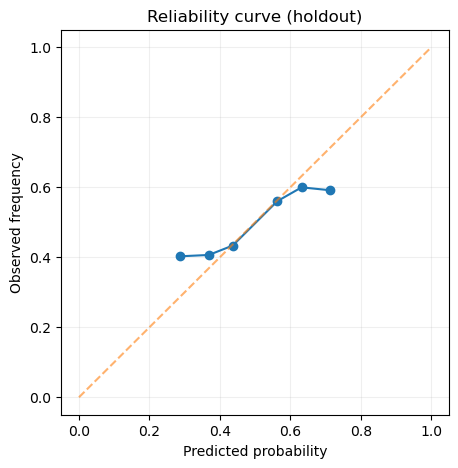

In [20]:
from sklearn.calibration import calibration_curve

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if mask.sum() == 0: 
            continue
        conf = y_prob[mask].mean()
        acc  = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return ece

p_test = p_test if 'p_test' in locals() else calibrated.predict_proba(X[test_mask])[:,1]
ece = expected_calibration_error(y[test_mask], p_test, n_bins=10)
print(f"ECE (10 bins): {ece:.4f}")

prob_true, prob_pred = calibration_curve(y[test_mask], p_test, n_bins=10)
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, 'o-')
plt.plot([0,1],[0,1],'--', alpha=0.6)
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Reliability curve (holdout)')
plt.grid(alpha=0.2); plt.show()


## Experiment: Elo decay constant τ sweep
We rebuild the feature pipeline for several τ values and compare holdout metrics to pick the best τ.

In [35]:
best = None
for tau in [400.0, 800.0, 1200.0]:
    work_players = compute_elos(df, init=1500, k=24, tau=tau)
    # re-run your feature builders here (rolling/break/best_move if any, synergy, enemy fam, role history)
    work_players = add_rolling_stats_side(work_players)
    work_players = add_break_features(work_players, GAP_THRESH)
    work_players = add_role_history_stats(work_players, windows=(5,20,50))
    work_players = add_synergy_features(work_players)
    work_players = add_enemy_familiarity_features(work_players)
    team_tall    = build_team_agg(work_players, add_ratios=False)  # we dropped ratios globally

    # select features (reuse your selection code but without ratios)
    team_only = [c for c in team_tall.columns if c.startswith((
        'pre_elo_', 'gap_id_clipped_', 'long_break_flag_', 'place_',
        'win_streak_', 'loss_streak_', 'synergy_mean_team_', 'synergy_max_team_',
        'enemy_fam_', 'games_played_',
        'don_pre_elo_role','sheriff_pre_elo_role','black_mean_pre_elo_role','red_mean_pre_elo_role',
        'don_games_in_role','sheriff_games_in_role','black_mean_games_in_role','red_mean_games_in_role',
        'don_wr20','sheriff_wr20','black_mean_wr20','red_mean_wr20','meta_period_first'
    ))]
    delta_feats = [c for c in team_tall.columns if c.endswith('__delta_maf_minus_cit')]
    USED = [c for c in sorted(set(team_only + delta_feats)) if 'team_win' not in c]

    Xg = team_tall[USED].fillna(0); yg = team_tall['team_win_team'].astype(int).values
    tg = team_tall['game_max_id'].values
    q70,q85 = np.quantile(tg,[0.70,0.85]); Tr = tg<=q85; Cal=(tg>q70)&(tg<=q85); Te=tg>q85

    m = LGBMClassifier(**best_params if 'best_params' in globals() else dict(
        n_estimators=1200, learning_rate=0.01, num_leaves=127, min_data_in_leaf=60,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, reg_alpha=0.5,
        class_weight='balanced', random_state=42, n_jobs=-1))
    m.fit(Xg[Tr], yg[Tr])
    cal = CalibratedClassifierCV(m, cv='prefit', method='sigmoid').fit(Xg[Cal], yg[Cal])
    pt = cal.predict_proba(Xg[Te])[:,1]
    auc = roc_auc_score(yg[Te], pt); ll = log_loss(yg[Te], pt)
    print(f"tau={tau:.0f}  AUC={auc:.4f}  LogLoss={ll:.4f}")
    if best is None or auc > best[0]:
        best = (auc, ll, tau)

print("Best tau:", best)


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 68240, number of negative: 68240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8890
[LightGBM] [Info] Number of data points in the train set: 136480, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
tau=400  AUC=0.5911  LogLoss=0.6939
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 68240, number of negative: 68240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8890
[LightGBM] [Info] Number of data points in the train set: 136480, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
tau=800  AUC=0.5906  LogLoss=0.6942
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 68240, number of negative: 68240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8890
[LightGBM] [Info] Number of data points in the train set: 136480, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
tau=1200  AUC=0.5903  LogLoss=0.6942
Best tau: (0.5911269774909778, 0.693871851259183, 400.0)


## CatBoost baseline (optional)
A strong tabular model complementary to LightGBM. We'll train on the same splits and compare holdout metrics.


In [21]:
# Optional: if not installed, run in terminal: pip install catboost
from catboost import CatBoostClassifier, Pool

# pick features and cat columns for CatBoost
X_train, y_train = X[train_mask], y[train_mask]
X_cal,   y_cal   = X[cal_mask],   y[cal_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

cat_features = []
if 'meta_period_mean' in X.columns:
    cat_features.append(X.columns.get_loc('meta_period_mean'))

train_pool = Pool(X_train, y_train, cat_features=cat_features or None)
cal_pool   = Pool(X_cal,   y_cal,   cat_features=cat_features or None)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features or None)

cat = CatBoostClassifier(
    iterations=2500,
    learning_rate=0.02,
    depth=8,
    l2_leaf_reg=3.0,
    random_seed=42,
    eval_metric='Logloss',
    loss_function='Logloss',
    class_weights=[1.0, 2.3],  # adjust for imbalance
    use_best_model=True,
    verbose=200
)
cat.fit(train_pool, eval_set=cal_pool)
p_test_cat = cat.predict_proba(test_pool)[:,1]

print("\nCatBoost — Holdout")
print("LogLoss:", log_loss(y_test, p_test_cat))
print("ROC-AUC:", roc_auc_score(y_test, p_test_cat))
print("Brier  :", brier_score_loss(y_test, p_test_cat))


0:	learn: 0.6895594	test: 0.6895595	best: 0.6895595 (0)	total: 208ms	remaining: 8m 39s
200:	learn: 0.6025043	test: 0.6024494	best: 0.6024494 (200)	total: 7.65s	remaining: 1m 27s
400:	learn: 0.5986441	test: 0.5989709	best: 0.5989709 (400)	total: 14.7s	remaining: 1m 16s
600:	learn: 0.5946972	test: 0.5951594	best: 0.5951594 (600)	total: 22.3s	remaining: 1m 10s
800:	learn: 0.5904542	test: 0.5909762	best: 0.5909762 (800)	total: 29.3s	remaining: 1m 2s
1000:	learn: 0.5859827	test: 0.5865223	best: 0.5865223 (1000)	total: 36.3s	remaining: 54.4s
1200:	learn: 0.5815127	test: 0.5820509	best: 0.5820509 (1200)	total: 43.9s	remaining: 47.5s
1400:	learn: 0.5772884	test: 0.5779059	best: 0.5779059 (1400)	total: 51s	remaining: 40s
1600:	learn: 0.5730020	test: 0.5736640	best: 0.5736640 (1600)	total: 58.1s	remaining: 32.6s
1800:	learn: 0.5689406	test: 0.5696475	best: 0.5696475 (1800)	total: 1m 5s	remaining: 25.4s
2000:	learn: 0.5650575	test: 0.5657131	best: 0.5657131 (2000)	total: 1m 12s	remaining: 18.1s
2

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
# freeze the fitted cat model for calibration
cat_cal = CalibratedClassifierCV(cat, cv='prefit', method='sigmoid').fit(X[cal_mask], y[cal_mask])

p_test_cat_cal = cat_cal.predict_proba(X[test_mask])[:,1]

# compare
print("\nCatBoost Calibrated — Holdout")
print("LogLoss:", log_loss(y[test_mask], p_test_cat_cal))
print("ROC-AUC:", roc_auc_score(y[test_mask], p_test_cat_cal))
print("Brier  :", brier_score_loss(y[test_mask], p_test_cat_cal))

# simple blend
p_blend = 0.5 * p_test + 0.5 * p_test_cat_cal   # p_test is calibrated LGBM
print("\nBlend(0.5·LGBM + 0.5·Cat) — Holdout")
print("LogLoss:", log_loss(y[test_mask], p_blend))
print("ROC-AUC:", roc_auc_score(y[test_mask], p_blend))
print("Brier  :", brier_score_loss(y[test_mask], p_blend))

### Feature cleaning

In [22]:
import pandas as pd
fi = pd.DataFrame({
    'feature': X.columns,
    'gain': final.booster_.feature_importance(importance_type='gain')
}).sort_values('gain', ascending=False)
fi.head(15)


,feature,gain
1,black_mean_pre_elo_role,83985.988385
59,red_mean_games_in_role,13423.527174
55,pre_elo_side_mean__delta_maf_minus_cit,13142.434599
41,place_std__delta_maf_minus_cit,10243.898983
53,pre_elo_role_mean__delta_maf_minus_cit,10020.883934
47,pre_elo_min__delta_maf_minus_cit,9055.357470
21,gap_id_clipped_max__ratio_maf_over_cit,8689.043122
52,pre_elo_role_mean,8649.423267
49,pre_elo_q25__delta_maf_minus_cit,8436.906132
42,pre_elo_max,8414.286989


## Optuna tuning (small)
Search a handful of LightGBM hyperparameters for better logloss on a validation split drawn from the train window.


In [ ]:
import optuna
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import KFold

# --- time-aware 3-fold CV on the TRAIN window only ---
# sort train indices by time
train_idx = np.where(train_mask)[0]
order = np.argsort(time_key[train_mask])
train_idx = train_idx[order]

def time_folds(idx, n_folds=3):
    splits = np.array_split(idx, n_folds)
    for i in range(n_folds):
        va = splits[i]
        tr = np.concatenate([splits[j] for j in range(n_folds) if j != i])
        yield tr, va

def objective(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 800, 2500, step=200),
        learning_rate=trial.suggest_float("learning_rate", 0.004, 0.02, log=True),
        num_leaves=trial.suggest_int("num_leaves", 63, 191, step=16),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 30, 120, step=10),
        subsample=trial.suggest_float("subsample", 0.7, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.7, 1.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 3.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 3.0),
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    aucs = []
    for tr, va in time_folds(train_idx, n_folds=3):
        m = LGBMClassifier(**params)
        m.fit(
            X.iloc[tr], y[tr],
            eval_set=[(X.iloc[va], y[va])],
            eval_metric='auc',
            callbacks=[early_stopping(100), log_evaluation(0)]
        )
        p = m.predict_proba(X.iloc[va])[:,1]
        aucs.append(roc_auc_score(y[va], p))
    return 1 - np.mean(aucs)  # minimize (1-AUC)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=False)
best_params = study.best_params
best_params.update(dict(class_weight='balanced', random_state=42, n_jobs=-1))
print("Best params:", best_params)

# --- retrain on full train, calibrate on cal, test on holdout ---
final = LGBMClassifier(**best_params)
# optional inner-early stopping on last 10% of train window
tr_time = time_key[train_mask]; q90 = np.quantile(tr_time, 0.90)
inner_tr = train_mask & (time_key <= q90)
inner_va = train_mask & (time_key >  q90)
final.fit(X[inner_tr], y[inner_tr],
          eval_set=[(X[inner_va], y[inner_va])],
          eval_metric='logloss',
          callbacks=[early_stopping(100), log_evaluation(0)])

# calibrate with sigmoid on cal window
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(final, cv='prefit', method='sigmoid').fit(X[cal_mask], y[cal_mask])

p_test = calibrated.predict_proba(X[test_mask])[:,1]
print("\nTuned LGBM (proper) — Holdout")
print("LogLoss:", log_loss(y[test_mask], p_test))
print("ROC-AUC:", roc_auc_score(y[test_mask], p_test))
print("Brier  :", brier_score_loss(y[test_mask], p_test))


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-10 17:31:11,909] A new study created in memory with name: no-name-7a2b0421-fa09-4829-a528-74301248c5ef


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2025-10-10 17:32:02,752] Trial 0 finished with value: 0.6946246238444234 and parameters: {'n_estimators': 2000, 'learning_rate': 0.017965789759657957, 'num_leaves': 175, 'min_data_in_leaf': 30, 'subsample': 0.8632443354753648, 'colsample_bytree': 0.9026991566091438, 'reg_lambda': 0.7966739646236307, 'reg_alpha': 0.4620496367691833}. Best is trial 0 with value: 0.6946246238444234.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2025-10-10 17:33:42,881] Trial 1 finished with value: 0.6910782839315014 and parameters: {'n_estimators': 3000, 'learning_rate': 0.006511099303578196, 'num_leaves': 191, 'min_data_in_leaf': 100, 'subsample': 0.9030256770853151, 'colsample_bytree': 0.9309451416823362, 'reg_lambda': 1.3576600781387818, 'reg_alpha': 2.355864075146791}. Best is trial 1 with value: 0.6910782839315014.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2025-10-10 17:34:23,858] Trial 2 finished with value: 0.6872414176576901 and parameters: {'n_estimators': 1600, 'learning_rate': 0.0071479455214853785, 'num_leaves': 143, 'min_data_in_leaf': 40, 'subsample': 0.7400226206959274, 'colsample_bytree': 0.8978503653085641, 'reg_lambda': 2.9338706519146625, 'reg_alpha': 0.9343110171205256}. Best is trial 2 with value: 0.6872414176576901.


[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110


[I 2025-10-10 17:35:01,271] Trial 3 finished with value: 0.6904830154063281 and parameters: {'n_estimators': 1600, 'learning_rate': 0.016485228562231283, 'num_leaves': 127, 'min_data_in_leaf': 110, 'subsample': 0.7860886646986935, 'colsample_bytree': 0.8302685706514125, 'reg_lambda': 0.09856498757226073, 'reg_alpha': 2.815827630672395}. Best is trial 2 with value: 0.6872414176576901.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-10-10 17:35:21,592] Trial 4 finished with value: 0.6861639745299829 and parameters: {'n_estimators': 1200, 'learning_rate': 0.011593410016254939, 'num_leaves': 79, 'min_data_in_leaf': 100, 'subsample': 0.829257245782629, 'colsample_bytree': 0.9092587213962877, 'reg_lambda': 0.45888549632286146, 'reg_alpha': 1.6119769925525702}. Best is trial 4 with value: 0.6861639745299829.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2025-10-10 17:36:12,005] Trial 5 finished with value: 0.6863473913314309 and parameters: {'n_estimators': 1400, 'learning_rate': 0.005417003646173663, 'num_leaves': 175, 'min_data_in_leaf': 50, 'subsample': 0.8004668745597411, 'colsample_bytree': 0.9639816477324334, 'reg_lambda': 1.5784155066329606, 'reg_alpha': 1.9114754332169688}. Best is trial 4 with value: 0.6861639745299829.


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120


[I 2025-10-10 17:37:58,379] Trial 6 finished with value: 0.6895432771748213 and parameters: {'n_estimators': 3200, 'learning_rate': 0.006942922717297027, 'num_leaves': 143, 'min_data_in_leaf': 120, 'subsample': 0.7479753642885805, 'colsample_bytree': 0.7263797943108581, 'reg_lambda': 1.3471040187637375, 'reg_alpha': 1.6002099342067453}. Best is trial 4 with value: 0.6861639745299829.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2025-10-10 17:39:09,091] Trial 7 finished with value: 0.6893030517778277 and parameters: {'n_estimators': 2400, 'learning_rate': 0.0064722500018125064, 'num_leaves': 207, 'min_data_in_leaf': 100, 'subsample': 0.8588348929519485, 'colsample_bytree': 0.8143081463940149, 'reg_lambda': 2.05384268001337, 'reg_alpha': 0.7416468066803069}. Best is trial 4 with value: 0.6861639745299829.


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120


[I 2025-10-10 17:39:40,403] Trial 8 finished with value: 0.6883347383121106 and parameters: {'n_estimators': 1400, 'learning_rate': 0.012784058501713054, 'num_leaves': 127, 'min_data_in_leaf': 120, 'subsample': 0.7880948913810106, 'colsample_bytree': 0.9182818376404835, 'reg_lambda': 2.2155904580368633, 'reg_alpha': 2.840701900500785}. Best is trial 4 with value: 0.6861639745299829.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2025-10-10 17:40:21,855] Trial 9 finished with value: 0.6945821944569877 and parameters: {'n_estimators': 2600, 'learning_rate': 0.021699063138672942, 'num_leaves': 79, 'min_data_in_leaf': 100, 'subsample': 0.9900844542331435, 'colsample_bytree': 0.7405334712996994, 'reg_lambda': 1.1376236944791618, 'reg_alpha': 1.0503793620034316}. Best is trial 4 with value: 0.6861639745299829.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2025-10-10 17:41:31,029] Trial 10 finished with value: 0.7176777423435953 and parameters: {'n_estimators': 2000, 'learning_rate': 0.029918948161721713, 'num_leaves': 255, 'min_data_in_leaf': 70, 'subsample': 0.9363319017873359, 'colsample_bytree': 0.7960140601170906, 'reg_lambda': 0.10738233343028986, 'reg_alpha': 0.15076475317731175}. Best is trial 4 with value: 0.6861639745299829.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-10-10 17:41:52,752] Trial 11 finished with value: 0.6854539589871894 and parameters: {'n_estimators': 1200, 'learning_rate': 0.009525319821443211, 'num_leaves': 63, 'min_data_in_leaf': 60, 'subsample': 0.810004385774661, 'colsample_bytree': 0.9912082139228305, 'reg_lambda': 0.6041350090343843, 'reg_alpha': 1.7703187049908027}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2025-10-10 17:42:10,857] Trial 12 finished with value: 0.685548442005242 and parameters: {'n_estimators': 1200, 'learning_rate': 0.009481695978701141, 'num_leaves': 63, 'min_data_in_leaf': 70, 'subsample': 0.8205782045048107, 'colsample_bytree': 0.9977582484476154, 'reg_lambda': 0.5333071686358678, 'reg_alpha': 1.9928554149550564}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2025-10-10 17:42:34,145] Trial 13 finished with value: 0.6855699741818715 and parameters: {'n_estimators': 1200, 'learning_rate': 0.009625944182200207, 'num_leaves': 63, 'min_data_in_leaf': 70, 'subsample': 0.7074280699623001, 'colsample_bytree': 0.994358951041993, 'reg_lambda': 0.6543536389960545, 'reg_alpha': 2.1756285127066586}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2025-10-10 17:43:14,058] Trial 14 finished with value: 0.6875861841323119 and parameters: {'n_estimators': 1800, 'learning_rate': 0.00906552165709129, 'num_leaves': 95, 'min_data_in_leaf': 60, 'subsample': 0.8249775418293589, 'colsample_bytree': 0.9990940313069375, 'reg_lambda': 0.8873499123930381, 'reg_alpha': 1.3193628982161623}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2025-10-10 17:43:42,063] Trial 15 finished with value: 0.6864947671995209 and parameters: {'n_estimators': 1200, 'learning_rate': 0.009319540674957648, 'num_leaves': 111, 'min_data_in_leaf': 80, 'subsample': 0.8943060858306945, 'colsample_bytree': 0.9646936167395734, 'reg_lambda': 0.4000562880836497, 'reg_alpha': 2.3063641376159}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2025-10-10 17:44:05,995] Trial 16 finished with value: 0.6868965837342117 and parameters: {'n_estimators': 1600, 'learning_rate': 0.012444135108549317, 'num_leaves': 63, 'min_data_in_leaf': 80, 'subsample': 0.7550902778329385, 'colsample_bytree': 0.861556261795767, 'reg_lambda': 1.851454839909664, 'reg_alpha': 1.8967860264106489}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2025-10-10 17:44:47,763] Trial 17 finished with value: 0.6874450846755474 and parameters: {'n_estimators': 2200, 'learning_rate': 0.008431323604247734, 'num_leaves': 95, 'min_data_in_leaf': 20, 'subsample': 0.8929607501577335, 'colsample_bytree': 0.9522343483618647, 'reg_lambda': 1.0155859086480392, 'reg_alpha': 1.3367950195567257}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2025-10-10 17:46:21,673] Trial 18 finished with value: 0.6937391564837345 and parameters: {'n_estimators': 1800, 'learning_rate': 0.014212087231831315, 'num_leaves': 223, 'min_data_in_leaf': 50, 'subsample': 0.8335976113063307, 'colsample_bytree': 0.8655515265239156, 'reg_lambda': 0.3948759387299015, 'reg_alpha': 1.9489356673588052}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2025-10-10 17:47:03,081] Trial 19 finished with value: 0.6877785247216013 and parameters: {'n_estimators': 2600, 'learning_rate': 0.01094343012885043, 'num_leaves': 63, 'min_data_in_leaf': 80, 'subsample': 0.9409439603593309, 'colsample_bytree': 0.7680622808076036, 'reg_lambda': 2.8073586185531614, 'reg_alpha': 2.613719552138554}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2025-10-10 17:47:30,839] Trial 20 finished with value: 0.6858943431361021 and parameters: {'n_estimators': 1400, 'learning_rate': 0.008191716994277818, 'num_leaves': 95, 'min_data_in_leaf': 60, 'subsample': 0.8080141236238088, 'colsample_bytree': 0.9826728228940315, 'reg_lambda': 0.011747576528400305, 'reg_alpha': 2.569552357817997}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2025-10-10 17:47:50,763] Trial 21 finished with value: 0.6856606800446744 and parameters: {'n_estimators': 1200, 'learning_rate': 0.010242035936575399, 'num_leaves': 63, 'min_data_in_leaf': 70, 'subsample': 0.7102732275413681, 'colsample_bytree': 0.9937390633778533, 'reg_lambda': 0.6848402041259016, 'reg_alpha': 2.1221884906961743}. Best is trial 11 with value: 0.6854539589871894.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2025-10-10 17:48:15,267] Trial 22 finished with value: 0.684791584984768 and parameters: {'n_estimators': 1200, 'learning_rate': 0.005297930950828994, 'num_leaves': 79, 'min_data_in_leaf': 60, 'subsample': 0.7025458007472759, 'colsample_bytree': 0.9368339256711523, 'reg_lambda': 0.575738894401147, 'reg_alpha': 1.761722061669005}. Best is trial 22 with value: 0.684791584984768.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2025-10-10 17:48:37,082] Trial 23 finished with value: 0.6849216038835994 and parameters: {'n_estimators': 1400, 'learning_rate': 0.005088764162022918, 'num_leaves': 79, 'min_data_in_leaf': 50, 'subsample': 0.782804675609348, 'colsample_bytree': 0.942123097828612, 'reg_lambda': 0.495107517247728, 'reg_alpha': 1.7380772726630676}. Best is trial 22 with value: 0.684791584984768.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2025-10-10 17:49:11,734] Trial 24 finished with value: 0.6851216140943645 and parameters: {'n_estimators': 1400, 'learning_rate': 0.005059620975609049, 'num_leaves': 111, 'min_data_in_leaf': 40, 'subsample': 0.7670456787571096, 'colsample_bytree': 0.9400922229231039, 'reg_lambda': 1.0385091797390378, 'reg_alpha': 1.69017491567238}. Best is trial 22 with value: 0.684791584984768.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2025-10-10 17:49:52,559] Trial 25 finished with value: 0.6853995955181887 and parameters: {'n_estimators': 1800, 'learning_rate': 0.005145834352608521, 'num_leaves': 111, 'min_data_in_leaf': 40, 'subsample': 0.7691113907251793, 'colsample_bytree': 0.8816636561410796, 'reg_lambda': 1.1429925482136962, 'reg_alpha': 1.350739153162504}. Best is trial 22 with value: 0.684791584984768.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2025-10-10 17:50:18,958] Trial 26 finished with value: 0.6853107818185508 and parameters: {'n_estimators': 1400, 'learning_rate': 0.0058128846244499995, 'num_leaves': 111, 'min_data_in_leaf': 20, 'subsample': 0.7275466834280288, 'colsample_bytree': 0.9413446409799529, 'reg_lambda': 0.2394949229131682, 'reg_alpha': 1.0836356940619267}. Best is trial 22 with value: 0.684791584984768.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2025-10-10 17:50:51,730] Trial 27 finished with value: 0.685167283001098 and parameters: {'n_estimators': 1600, 'learning_rate': 0.00586641356210261, 'num_leaves': 95, 'min_data_in_leaf': 40, 'subsample': 0.770448128509426, 'colsample_bytree': 0.942001547267435, 'reg_lambda': 0.9202275043769373, 'reg_alpha': 1.7097808518372586}. Best is trial 22 with value: 0.684791584984768.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2025-10-10 17:51:45,797] Trial 28 finished with value: 0.6878094888023062 and parameters: {'n_estimators': 2000, 'learning_rate': 0.007617293174444146, 'num_leaves': 127, 'min_data_in_leaf': 50, 'subsample': 0.7300566543391459, 'colsample_bytree': 0.8848822548229961, 'reg_lambda': 1.651225298027351, 'reg_alpha': 1.480386126145145}. Best is trial 22 with value: 0.684791584984768.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11042
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2025-10-10 17:52:47,987] Trial 29 finished with value: 0.6867441486407846 and parameters: {'n_estimators': 2000, 'learning_rate': 0.005930753607439497, 'num_leaves': 159, 'min_data_in_leaf': 30, 'subsample': 0.7689546508985311, 'colsample_bytree': 0.9242415425214073, 'reg_lambda': 0.7626390194672624, 'reg_alpha': 0.7006447216838254}. Best is trial 22 with value: 0.684791584984768.


Best params: {'n_estimators': 1200, 'learning_rate': 0.005297930950828994, 'num_leaves': 79, 'min_data_in_leaf': 60, 'subsample': 0.7025458007472759, 'colsample_bytree': 0.9368339256711523, 'reg_lambda': 0.575738894401147, 'reg_alpha': 1.761722061669005}
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 68240, number of negative: 68240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11072
[LightGBM] [Info] Number of data points in the train set: 136480, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60

Tuned LGBM — Holdout
LogLoss: 0.6955443480241135
ROC-AUC: 0.5902593324681227
Brier  : 0.2500817242083936


### Sanity-Check 0 — Context
We assume you already have these variables from the notebook:
- `team_tall`  : the per-team dataset (2 rows per game)
- `USED_FEATS` : the list of feature column names used to train
- `X, y`       : features (DataFrame) and labels (numpy array)
- `groups`     : `game_id` for GroupKFold
- `time_key`   : `game_max_id` (time proxy per game)
- masks: `train_mask`, `cal_mask`, `test_mask`
- models: `final` (LightGBM before calibration), `calibrated` (after isotonic)

In [24]:
# from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss

# # Raw (uncalibrated) predictions on holdout
# p_test_raw = final.predict_proba(X[test_mask])[:, 1]
# print("RAW (no calibration) — holdout")
# print("LogLoss:", log_loss(y[test_mask], p_test_raw))
# print("AUC    :", roc_auc_score(y[test_mask], p_test_raw))
# print("Brier  :", brier_score_loss(y[test_mask], p_test_raw))

# # Calibrated (your current numbers)
# p_test_cal = calibrated.predict_proba(X[test_mask])[:, 1]
# print("\nCALIBRATED — holdout")
# print("LogLoss:", log_loss(y[test_mask], p_test_cal))
# print("AUC    :", roc_auc_score(y[test_mask], p_test_cal))
# print("Brier  :", brier_score_loss(y[test_mask], p_test_cal))


In [25]:
# rng = np.random.default_rng(42)
# y_shuffled = y.copy()
# y_shuffled[test_mask] = rng.permutation(y_shuffled[test_mask])

# print("Label-shuffled holdout:")
# print("LogLoss:", log_loss(y_shuffled[test_mask], p_test_cal))
# print("AUC    :", roc_auc_score(y_shuffled[test_mask], p_test_cal))
# print("Brier  :", brier_score_loss(y_shuffled[test_mask], p_test_cal))


In [26]:
# # Shuffle the order of X within the holdout
# X_test = X[test_mask].copy()
# X_test_shuffled = X_test.sample(frac=1.0, random_state=123)

# # Predict on shuffled features (same trained model)
# p_test_shufX = calibrated.predict_proba(X_test_shuffled)[:, 1]

# print("Feature-shuffled holdout:")
# print("LogLoss:", log_loss(y[test_mask], p_test_shufX))
# print("AUC    :", roc_auc_score(y[test_mask], p_test_shufX))
# print("Brier  :", brier_score_loss(y[test_mask], p_test_shufX))


In [27]:
# suspects = {'team_win','team_win_team',
#             'game_points','total_points',
#             'game_bonus','game_autobonus','best_move_bonus',
#             'killed_first','best_move'}
# bad = [c for c in USED_FEATS if any(s in c for s in suspects)]
# print("Forbidden features found:", bad)

## 6) Convert to per-game winner & accuracy
Pick the side with larger probability within each game on the holdout.

In [28]:
hold = team_tall.loc[test_mask, ['game_id','team','team_win_team']].copy()
hold['proba'] = p_test

# True side per game
true_side = hold[hold['team_win_team']==1].groupby('game_id')['team'].first()

# Predicted side by higher prob
pred_side = hold.groupby('game_id').apply(lambda g: g.loc[g['proba'].idxmax(),'team'])
acc = (pred_side == true_side.reindex(pred_side.index)).mean()
print("Per-game accuracy (holdout):", round(acc, 4))


Per-game accuracy (holdout): 0.5803


C:\Users\user\AppData\Local\Temp\ipykernel_27188\2849635908.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_side = hold.groupby('game_id').apply(lambda g: g.loc[g['proba'].idxmax(),'team'])


## 7) Save model & inference helpers


In [29]:
import joblib, json

joblib.dump(calibrated, ARTS/"lgbm_calibrated_pergame.joblib")
json.dump(USED_FEATS, open(ARTS/"pergame_features.json","w"))
print("Saved to:", ARTS)

def build_team_features_from_players(df_players: pd.DataFrame) -> pd.DataFrame:
    w = compute_elo(df_players)
    w = add_rolling_stats(w)

    aggs = {
        'pre_elo': ['mean','std','min','max', q25, q75],
        'roll5_win_rate': ['mean'],
        'roll20_win_rate': ['mean'],
        'career_win_rate': ['mean'],
        'games_played': ['mean','min','max', 'std']
    }
    if 'roll5_pts_mean' in w.columns:
        aggs['roll5_pts_mean'] = ['mean']
    if 'roll20_pts_mean' in w.columns:
        aggs['roll20_pts_mean'] = ['mean']

    ta = w.groupby(['game_id','team']).agg(aggs)
    ta.columns = ['_'.join(filter(None, map(str, c))).replace('<function ','').replace('>','') for c in ta.columns]
    ta = ta.reset_index()
    if 'id' in w.columns:
        gmaxid = w.groupby('game_id')['id'].max().rename('game_max_id')
        ta = ta.merge(gmaxid, on='game_id', how='left')

    wide = ta.pivot(index='game_id', columns='team')
    wide.columns = [f"{a}__{b}" for a,b in wide.columns]
    wide = wide.reset_index()

    def side_cols(side): return [c for c in wide.columns if c.endswith(f"__{side}") and c != 'game_id']
    maf_cols = side_cols('mafia')

    delta = pd.DataFrame({'game_id': wide['game_id']})
    for mcol in maf_cols:
        base = mcol[:-len("__mafia")]
        ccol = base + "__citizens"
        if ccol in wide.columns:
            delta[base + "__delta_maf_minus_cit"] = wide[mcol] - wide[ccol]

    team_tall_new = ta.merge(delta, on='game_id', how='left')
    return team_tall_new

def predict_game_winner_from_players(df_players_new: pd.DataFrame):
    tt = build_team_features_from_players(df_players_new)
    X_new = tt[USED_FEATS].fillna(0)
    proba = calibrated.predict_proba(X_new)[:,1]
    out = tt[['game_id','team']].copy()
    out['p_team_win'] = proba
    winners = out.loc[out.groupby('game_id')['p_team_win'].idxmax()].rename(columns={'team':'pred_team'})
    winners = winners[['game_id','pred_team','p_team_win']]
    return out, winners

print("Inference functions ready.")


Saved to: artifacts_game
Inference functions ready.


## 8) “Daily” monitoring (simulated)
Score newest ~2% of games by `game_max_id` to catch recent drift.

In [30]:
cut = np.quantile(time_key, 0.98)
daily_mask = time_key > cut
p_daily = calibrated.predict_proba(X[daily_mask])[:,1]
print("DAILY LogLoss:", log_loss(y[daily_mask], p_daily))
print("DAILY ROC-AUC:", roc_auc_score(y[daily_mask], p_daily))
print("DAILY Brier  :", brier_score_loss(y[daily_mask], p_daily))


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
DAILY LogLoss: 0.6909885399496766
DAILY ROC-AUC: 0.5954606325283922
DAILY Brier  : 0.2479330190642982
